In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, Normalizer

#metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn import metrics

import random
random.seed(48)


In [1]:
# import training and testing data, which was cleaned in notebook_1

model_train_df = pd.read_csv('../data/transformed_data/model_train_df.csv')
model_test_df = pd.read_csv('../data/transformed_data/model_test_df.csv')

NameError: name 'pd' is not defined

In [ ]:
# a function for scoring and pulling model metrics

def model_metrics(some_lr, scaled=False):

    if scaled:
        train_r2 = some_lr.score(X_train_sc, y_train)
        test_r2 = some_lr.score(X_test_sc, y_test)
        
    else:
        train_r2 = some_lr.score(X_train, y_train)
        test_r2 = some_lr.score(X_test, y_test)
    preds = some_lr.predict(X)
    resids_mean = (y - preds).mean()
    mae = metrics.mean_absolute_error(y, preds)
    resids = resids = y - preds
    rss = (resids ** 2).sum()
    mse = metrics.mean_squared_error(y, preds)
    rmse = np.sqrt(metrics.mean_squared_error(y, preds))
    cvs = cross_val_score(some_lr, X, y, cv=5).mean()
    f1 = f1_score(y, preds)
    class_report = classification_report(y, preds)

    final_dict={'Train R2 Score': train_r2,
                'Test R2 Score' : test_r2,
                'Mean of Residuals': resids_mean,
               'Mean Absolute Error': mae,
               'Residual Sum of Squares': rss,
               'Mean Squared Error': mse,
               'Root Mean Squared Error': rmse,
               'cross_val_score': cvs,
               'f1': f1}
    return final_dict, class_report

In [ ]:
X = model_train_df.drop(columns = ['target'])
y = model_train_df['target']

In [2]:
y.value_counts(normalize=True)

NameError: name 'y' is not defined

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=48)

In [25]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [26]:
model_metrics(nb)

{'Train R2 Score': 0.82949291433297,
 'Test R2 Score': 0.8260869565217391,
 'Mean of Residuals': -0.13879101657453025,
 'Mean Absolute Error': 0.17118828405747707,
 'Residual Sum of Squares': 34156,
 'Mean Squared Error': 0.17118828405747707,
 'Root Mean Squared Error': 0.4137490592828908,
 'cross_val_score': 0.8305659073569576}

In [9]:
logreg = LogisticRegression(max_iter=100_000)
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=100000)

In [13]:
model_metrics(logreg)

{'Train R2 Score': 0.9476500144094024,
 'Test R2 Score': 0.9479764440546298,
 'Mean of Residuals': 0.038030703227196865,
 'Mean Absolute Error': 0.05228469900713201,
 'Residual Sum of Squares': 10432,
 'Mean Squared Error': 0.05228469900713201,
 'Root Mean Squared Error': 0.22865847678827042,
 'cross_val_score': 0.9477102861678202}

In [29]:
coef = list(logreg.coef_)
features = list(X.columns)
income_coef = pd.DataFrame(zip(features, coef[0]), columns=['Feature', 'Coefficient'],index=features).drop(columns='Feature').sort_values(by='Coefficient', ascending=False)
income_coef

,Coefficient
veterans_benefits,0.232484
education_current_enrollment,0.164185
num_employed,0.162836
weeks_worked,0.065543
same_res_one_year_ago,0.047867
household_summary,0.043626
occupation_major,0.039731
education,0.039719
age,0.032691
worker_class,0.028602


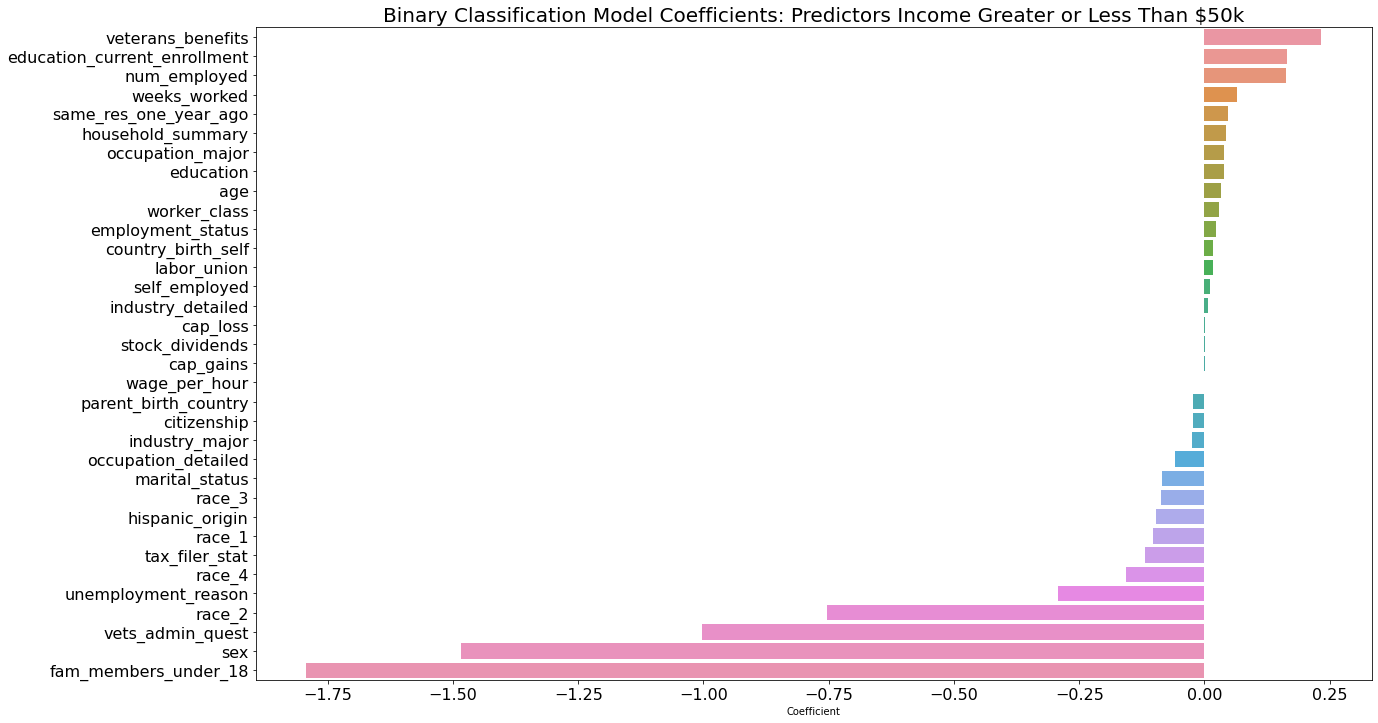

In [30]:
fig_dims = (20, 12)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(y = income_coef.index, x=income_coef['Coefficient'], ax=ax)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Binary Classification Model Coefficients: Predictors Income Greater or Less Than $50k', fontsize=20);

<Figure size 1440x1440 with 0 Axes>

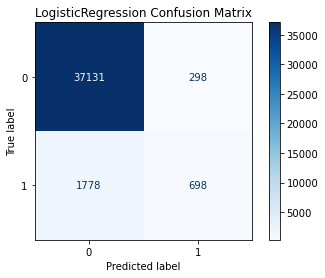

In [34]:
plt.figure(figsize=(20, 20))
plot_confusion_matrix(logreg, X_test, y_test, cmap='Blues', values_format='d')
plt.title('LogisticRegression Confusion Matrix');

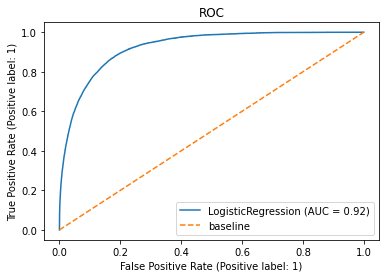

In [35]:
#ROC plot code is from General Assembly lesson 4.05.
plot_roc_curve(logreg, X, y)
plt.plot([0,1], [0,1], label = 'baseline', linestyle= '--')
plt.title('ROC')
plt.legend();

In [27]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [28]:
model_metrics(rf)

{'Train R2 Score': 0.9995426580962047,
 'Test R2 Score': 0.9548678110512467,
 'Mean of Residuals': 0.00547305323195822,
 'Mean Absolute Error': 0.009392400876089474,
 'Residual Sum of Squares': 1874,
 'Mean Squared Error': 0.009392400876089474,
 'Root Mean Squared Error': 0.0969143997354855,
 'cross_val_score': 0.9546067312583906}

In [36]:
rf_params = {
    'criterion': ['gini','entropy'],
    'min_samples_split': [2, 4],
    'n_estimators': [3, 5],
    'class_weight': ['balanced', 'balanced_subsample'],
    'ccp_alpha': [.0001, .001, .01, .1]

}

rf_gridsearch = GridSearchCV(RandomForestClassifier(), 
                              rf_params, 
                              cv=5, 
                              verbose=1)

In [37]:
rf_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'ccp_alpha': [0.0001, 0.001, 0.01, 0.1],
                         'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ['gini', 'entropy'],
                         'min_samples_split': [2, 4], 'n_estimators': [3, 5]},
             verbose=1)

In [39]:
rf_gridsearch.best_params_

{'ccp_alpha': 0.0001,
 'class_weight': 'balanced_subsample',
 'criterion': 'entropy',
 'min_samples_split': 4,
 'n_estimators': 5}

In [40]:
rf_gridsearch.best_score_

0.903187611025077

In [41]:
rf = RandomForestClassifier(ccp_alpha=0.0001)
rf.fit(X_train, y_train)

RandomForestClassifier(ccp_alpha=0.0001)

In [48]:
model_metrics(rf)

{'Train R2 Score': 0.9507574333721761,
 'Test R2 Score': 0.9512341811803032,
 'Mean of Residuals': 0.04151902286954386,
 'Mean Absolute Error': 0.04914721611042336,
 'Residual Sum of Squares': 9806,
 'Mean Squared Error': 0.04914721611042336,
 'Root Mean Squared Error': 0.22169171412216415,
 'cross_val_score': 0.9506974063902973,
 'f1': 0.4049757281553398,
 'classification report': '              precision    recall  f1-score   support\n\n           0       0.95      1.00      0.97    187141\n           1       0.81      0.27      0.40     12382\n\n    accuracy                           0.95    199523\n   macro avg       0.88      0.63      0.69    199523\nweighted avg       0.95      0.95      0.94    199523\n'}

In [52]:
estimators = [('knn', KNeighborsClassifier(p=1)),
              ('tree', DecisionTreeClassifier(random_state=42, ccp_alpha=0.001, min_samples_leaf=3, min_samples_split=3))]

stacks = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(), cv=7)

stacks.fit(X_train, y_train)


StackingClassifier(cv=7,
                   estimators=[('knn', KNeighborsClassifier(p=1)),
                               ('tree',
                                DecisionTreeClassifier(ccp_alpha=0.001,
                                                       min_samples_leaf=3,
                                                       min_samples_split=3,
                                                       random_state=42))],
                   final_estimator=RandomForestClassifier())

In [ ]:
model_metrics(stacks)